In [1]:
# General
from jax import jit
import jax.numpy as jnp
import numpy as np

from opt_einsum import contract
# Quantum
import optax
import pennylane as qml

# Plot
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

# Utils
import os
from typing import Tuple, List, Callable
from numpy.typing import NDArray
import itertools
import tqdm

# Custom
# import ANNNIgen
# import mpsgen
# import qcnn

class state:
    def __init__(self, L : int, h : float, k : float, shapes : NDArray, tensors : NDArray, _towave_func : Callable):
        """Single ANNNI MPS class

        Class containing a single MPS object for the ANNNI model

        Parameters
        ----------
        L : int 
            Number of sites
        h : float
            Value of h
        k : float or NDArray
            Value of k
        shapes : NDArray
            Matrix containing the shape of each site
        tensors : NDArray
            Simple 1D list of the tensor values
        _towave_func : Callable
            Funciton to transform the MPS into a wavefunction
            (INTERNAL FUNCTION TO THE CLASS MPS)
        """
        # Store the input values:
        self.L, self.h, self.k = L, h, k
        self.shapes = shapes.astype(int)
        # This needs some explanation:
        # 1. Start from `tensors`, it is just a list of value that have to be grouped in smaller
        #    tensors according to the shapes list, that defines the list of the smaller tensors
        # 2. Compute self.splits, it tells the indexes for splitting the full vector into
        #    the smaller tensors
        #    EX:
        #        [a,b,c,d,e,f,g,h] : full vector
        #         0 1 2 3 4 5 6 7    index
        #        [2,6]             : self.splits
        #        self.splits tells you how to break the full vector
        #        [a,b] [c,d,e,f] [g,h] : split vectors
        self.splits = np.cumsum(np.prod(shapes, axis=1)).astype(int)
        # 3. Compute the MPS:
        #     3.1: Group the elements in split vectors (not split tensors yet)
        #          np.array_split(tensors, self.splits)[:-1] 
        #          flat_tn = np.array_split(tensors, self.splits)[:-1] split vectors, List of L vectors
        #                    NOTE: np.array_split(tensors, self.splits)[-1] is empty
        #     3.2: Reshape each of the L vector into tensor with the shape declared in self.shape
        # 3.1 and 3.2 done together to avoid garbage collector shenanigans
        self.MPS = [site.reshape(self.shapes[i]) for i, site in enumerate(np.array_split(tensors, self.splits)[:-1])]

        self.towave = lambda : _towave_func(self.MPS)
        
class mps:
    def __init__(self, folder : str = '../tensor_data/', gpu : bool = False):
        """ANNNI MPS class

        Main class for the data analysis, it is a continer of: 
        > Multiple MPS
        > QCNN
        > QCNN training functions
        > Plot functions

        Parameters
        ----------
        folder : str
            Folder from where to read all necessary data
        gpu : bool
            if True, it tries to use the GPU with jax backend
        """

        def _get_info(file_string : str) -> Tuple[int, float, float, int, int]:
            """
            1. Split big string into array of string
            'shapes_sites_ANNNI_L_{L}_h_{h}_kappa_{k}'
                into
            ['shapes', 'sites', 'ANNNI', 'L', '{L}','h', '{h}', 'kappa', '{k}']
              0         1        2        3    4^    5    6^     7        8^
            2. Take the element 4, 6 and 8 
            """
            split_str = file_string.split('_')

            # return respectively:
            # L, h, k, precision on h, precision on k
            return int(split_str[4]), float(split_str[6]), float(split_str[8]), len(split_str[6].split('.')[1]), len(split_str[8].split('.')[1])
        
        def _toprob(label):
            """
            Converts a label into a probability vector of a 2-qubits state. 
            It is needed in the loss function of the QCNN since it uses the 
            Multi-class cross entropy 

            * 0 -> [1,0,0,0]
            * 1 -> [0,1,0,0]
            * 2 -> [0,0,1,0]
            * 3 -> [0,0,0,1]
            """
            prob = np.array([0]*4)
            prob[label] = 1
            return prob
        
        ###########################
        #     VALUES ASSIGNS.     #
        ###########################
        self.path = folder

        # Color for representing plots with
        #   3 Phases (Ferromagnetic, Paramagnetic, Antiphase)
        #   4 Phases : 3 Phases + Floating Phase
        self.col3 = [[0.456, 0.902, 0.635, 1],
                     [0.400, 0.694, 0.800, 1],
                     [0.922, 0.439, 0.439, 1]]

        self.col4 = [[0.456, 0.902, 0.635, 1],
                     [0.400, 0.694, 0.800, 1],
                     [1.000, 0.514, 0.439, 1],
                     [0.643, 0.012, 0.435, 1]]
        
        self.col8 = [[0.5, 0.9, 0.6, 1],
                     [0.4, 0.7, 0.8, 1],
                     [1.0, 0.5, 0.4, 1],
                     [0.9, 0.9, 0.0, 1],
                     [0.5/2, 0.9/2, 0.6/2, 1],
                     [0.4/2, 0.7/2, 0.8/2, 1],
                     [1.0/2, 0.5/2, 0.4/2, 1],
                     [0.9/2, 0.9/2, 0.0/2, 1]]

        # Relative colormaps
        self.cm3 = ListedColormap(self.col3, name='color3')
        self.cm4 = ListedColormap(self.col4, name='color4')
        self.cm8 = ListedColormap(self.col8, name='color8')

        ###########################
        #      CHECK FOLDER       #
        ###########################
        
        # Check if folder exists
        try: 
            files_all        = np.array(os.listdir(folder))
            self.files_shape = files_all[np.char.startswith(files_all,'shapes_sites')]
            self.files_tens  = files_all[np.char.startswith(files_all,'tensor_sites')]
        except:
            raise TypeError(f'Folder {folder} not found')
        
        # Check if files are okay
        Ls_shape, hs_shape, ks_shape, hs_shape_prec, ks_shape_prec = [], [], [], [], []
        Ls_tens,  hs_tens,  ks_tens,  hs_tens_prec,  ks_tens_prec  = [], [], [], [], []
        for file in self.files_shape:
            L, h, k, hprec, kprec = _get_info(file)
            Ls_shape.append(L)
            hs_shape.append(h)
            ks_shape.append(k)
            hs_shape_prec.append(hprec)
            ks_shape_prec.append(kprec)
        for file in self.files_tens:
            L, h, k, hprec, kprec = _get_info(file)
            Ls_tens.append(L)
            hs_tens.append(h)
            ks_tens.append(k)
            hs_tens_prec.append(hprec)
            ks_tens_prec.append(kprec)

        # Check on L
        if len(np.unique(Ls_shape)) > 1 or len(np.unique(Ls_tens)) > 1:
            raise ValueError(f'L has multiple values')
        elif Ls_shape[0] != Ls_tens[0]:
            raise ValueError(f'L has inconsistent values')
        # otherwise L is okay:
        self.L = Ls_shape[0]

        # TODO: Check on h and k

        self.hs = np.sort(np.unique(hs_shape))
        self.ks = np.sort(np.unique(ks_shape))

        # Check on precisions
        if len(np.unique(hs_shape_prec + hs_tens_prec)) > 1 or len(np.unique(ks_shape_prec + ks_tens_prec)) > 1: 
            raise ValueError('Inconsistent precisions in files')
        self.h_prec = hs_shape_prec[0]
        self.k_prec = ks_shape_prec[0]

        # Format of the file names:
        # shape_file  : shape_sites_ANNNI_L_{N}_h_{h}_kappa_{k}
        self.shape_str  = lambda h, k : folder+f'shapes_sites_ANNNI_L_{self.L}_h_{h:.{self.h_prec}f}_kappa_{k:.{self.k_prec}f}'
        # tensor_file : shape_sites_ANNNI_L_{N}_h_{h}_kappa_{k}
        self.tensor_str = lambda h, k : folder+f'tensor_sites_ANNNI_L_{self.L}_h_{h:.{self.h_prec}f}_kappa_{k:.{self.k_prec}f}'

        ###########################
        #      LOAD ALL MPS       #
        ###########################
        self.mpstowavefunc_subscript = mpsgen.get_subscript(self.L)
        if gpu:
            self.get_psi = lambda TT: contract(self.mpstowavefunc_subscript, *TT, backend='jax').flatten()
        else:
            self.get_psi = lambda TT: contract(self.mpstowavefunc_subscript, *TT).flatten() # type: ignore

        self.n_states = len(self.hs)*len(self.ks)
        self.MPS      = np.empty((self.n_states), dtype=object)
        self.Hparams  = np.full((self.n_states,2), np.nan)
        # We save the labels as integers (0,1,2,3) and as 2-qubits states
        # for an easier implementaion with the QCNN
        self.labels3, self.labels4 = np.full(self.n_states, np.nan, dtype=int), np.full(self.n_states, np.nan, dtype=int)
        self.probs3, self.probs4   = np.full((self.n_states,4), np.nan, dtype=int), np.full((self.n_states,4), np.nan, dtype=int)
        # Well load all the states using h as inner variable loop
        # With this, I am assuming the variables h and k are disposed
        # into a grid, uniformly spaced
        # TODO: Read directly from the folder
        
        for i, (h,k) in enumerate(itertools.product(self.hs, self.ks)):
            # Weird for loop, I know, it is equivalent of performing a nested for loops for h in hs and k in ks
            # + the enumerate loop variable:
            # i | h | k |
            # ----------|
            # 0 | 0 | 0 |
            # 1 | 1 | 0 | 
            # ...
            y3, y4 = ANNNIgen.get_labels(h,k)
            shapes  = np.loadtxt(self.shape_str(h,k)).astype(int)
            tensors = np.loadtxt(self.tensor_str(h,k))

            self.Hparams[i] = h, k
            self.labels3[i], self.labels4[i] = y3, y4
            self.probs3[i],  self.probs4[i]  = _toprob(y3), _toprob(y4)
            self.MPS[i] = state(self.L, h, k, shapes, tensors, self.get_psi)

        # In the next comments, by analytical I refer to the points
        # being in either of the two axes (k = 0 OR h = 0 (or being inclusive))
        # those are the points which labels can be obtained through
        # analytical computation 

        # Additionally, create a mask for all the analytical points
        self.mask_analitical = np.logical_or(self.Hparams[:,0] == 0, self.Hparams[:,1] == 0) # type: ignore

        # Mask for all the analytical ferromagnetic points
        self.mask_analitical_ferro = np.logical_or(np.logical_and(self.Hparams[:,0] <= 1, self.Hparams[:,1] == 0),
                                                   np.logical_and(self.Hparams[:,0] == 0, self.Hparams[:,1] < .5))
        # Mask for all the analytical paramagnetic points
        self.mask_analitical_para  = np.logical_and(self.Hparams[:,0] >  1, self.Hparams[:,1] ==  0)
        # Mask for all the analytical antiphase points
        self.mask_analitical_anti  = np.logical_and(self.Hparams[:,0] == 0, self.Hparams[:,1] >= .5)
        
        self.qcnn = qcnn.qcnn(self.L)

    def _train(self, epochs, PSI, Y, opt_state):
        """
        Internal simple training function, to be called by other functions
        """
        params = self.qcnn.PARAMS # Get the parameters from the class

        progress = tqdm.tqdm(range(epochs), position=0, leave=True)
        for epoch in range(epochs):
            # TODO: Fix accuracy function
            params, opt_state, train_loss, accuracy = self.qcnn.update(opt_state, PSI, params, Y)

            # Update progress bar
            progress.update(1)
            progress.set_description(f'Loss: {train_loss:.5f}')
            
        # Update the parameters after the training and return the new optimizer
        # state, (for performing multiple trainings)
        self.qcnn.PARAMS = params 
        return opt_state
    
    # TODO: Add batching functionality
    def train(self, epochs : int = 100, train_indices : NDArray = np.array([]), 
                    labels4 : bool = False,
                    batch_size : int = 0, lr : float = 1e-2):
        """Training function

        Training function assuming 3(4) Phases: 
        Ferromagnetic, Paramagnetic and Antiphase (Floating Phase)

        Parameters
        ----------
        epochs : int
            Number of epochs
        train_indices : NDArray
            Indexes of points to train
        labels4 : boot
            If True, use the 4-labels
        batch_size : int
            Number of MPS to used as input in a batch
        lr : float
            Learning Rate
        """
        self.qcnn.optimizer = optax.adam(learning_rate=lr)

        probs = self.probs4 if labels4 else self.probs3

        if len(train_indices) == 0:
            # Set the analytical points as training inputs
            train_indices = np.arange(len(self.MPS)).astype(int)[self.mask_analitical]
        else:         
            train_indices = train_indices

        opt_state = self.qcnn.optimizer.init(self.qcnn.PARAMS)
        if batch_size == 0:
            STATES  = jnp.array([mpsclass.towave() for mpsclass in self.MPS[train_indices]])
            YPROBS = probs[train_indices]
            # Y     = self.labels3[train_indices]
            print('Labels:', np.unique(np.argmax(YPROBS,axis=1)))
            print('Number of training points:', len(YPROBS))
            self._train(epochs, STATES, YPROBS, opt_state)
        else: 
            raise NotImplementedError("TODO: Batching not implemented, check model.train_rotate")
        
    def train_rotate(self, labels4 : bool = False, analytical : bool = True,
                     samples_per_class : int = 10,
                     epochs : int = 100, generations : int = 10,
                     lr : float = 1e-2,
                     show_samples : bool = True):
        """Training function

        Training function, different subsets of the input states will drawn randomly on rotation

        Parameters
        ----------
        labels4 : bool
            If True, use the 4-labels
        analytical : bool
            If True, only the analytical states will be drawn (this makes floating phase points being excluded)
        samples_per_class : int
            Number of states per class to be considered at the same time, tune it for memory optimization.
        epochs : int
            Number of epochs, an epoch is the number of training steps made on the same subset of inputs
        generations : int
            Number of generations, at the start of a generation, new inputs will be drawn and `epochs` training step will be perfomed
        lr : float
            Learning Rate
        show_samples : bool
            If True, show the samples drawn at each generation
        """ 
        
        # By default, we consider each possible point
        mask = np.arange(len(self.hs) * len(self.ks))

        # Prepare training, check input variables:
        if labels4:
            n_samples = [samples_per_class]*4 
            probs = self.probs4
            labels = self.labels4
        else:
            n_samples = [samples_per_class]*3
            probs = self.probs3
            labels = self.labels3

        if analytical:
            mask = mask[self.mask_analitical]
            if labels4:
                print('Floating phase instance is excluded (change analytical to False)')
                n_samples[-1] = 0 # if analytical, we do not have samples of the floating phase class 

        self.qcnn.optimizer = optax.adam(learning_rate=lr)
        opt_state = self.qcnn.optimizer.init(self.qcnn.PARAMS)

        gen_progress = tqdm.tqdm(range(generations))
        for gen in gen_progress:
            gen_progress.set_description(f'Generation: {gen}/{generations}')

            X = np.array([])
            samples_map = copy.copy(self.labels4)
            for phase, samples in enumerate(n_samples):
                pool = np.intersect1d(mask, np.where(labels == phase))
                x = np.random.choice(pool, samples, replace=False)
                samples_map[x] = 4 + phase
                X = np.append(X, x)

            X = X.astype(int)
            if show_samples:
                print(X)
                print(self.labels4[X])
                plt.figure(figsize=(5,5))
                ANNNIgen.plot_layout(self, True, True, True, title='', figure_already_defined = True)
                plt.imshow(np.flip(np.reshape(samples_map, (len(self.hs), len(self.ks))), axis=0), cmap=self.cm8)
                plt.show() 
                
            STATES  = jnp.array([mpsclass.towave() for mpsclass in self.MPS[X]])
            YPROBS = probs[X]
            
            # Y     = self.labels3[train_indices]
            print(f'Generation: {gen}')
            print('Labels:', np.unique(np.argmax(YPROBS,axis=1)))
            print('Number of training points:', len(YPROBS))
            opt_state = self._train(epochs, STATES, YPROBS, opt_state)

            gen_progress.update(1)

    # TODO: Add batching functionality
    def predict(self, batch_size : int = 0, plot : bool = True, eachclass : bool = False):
        """Output the predicted phases

        Output the predicted phases

        Parameters
        ----------
        batch_size : int
            Number of MPS to used as input in a batch
        plot : bool
            if True, it plots
        eachclass : bool 
            if True, it plots the probability of each class separately
        """
        if batch_size == 0:
            STATES = jnp.array([mpsclass.towave() for mpsclass in self.MPS])
            
            PREDICTIONS = self.qcnn.jv_q_circuit(STATES, self.qcnn.PARAMS)
        else: 
            raise NotImplementedError("TODO: Batching")

        # PREDICTIONS is a (h*k, 4) array
        # The values in the axis=1 represent the probability of each class. 
        # Computing the argmax on that axis outputs the class the model is most
        # confident of
        ARGPREDICTIONS = np.argmax(PREDICTIONS, axis=1)

        cmap = self.cm3
        # If it detected a 4th class, the colormap is different
        if len(np.unique(ARGPREDICTIONS)) == 4:
            cmap = self.cm4 
    
        if plot: 
            ANNNIgen.plot_layout(self, True, True, True, 'prediction', figure_already_defined = False)
            plt.imshow(np.flip(np.reshape(ARGPREDICTIONS, (len(self.hs), len(self.ks))), axis=0), cmap=cmap)

            if eachclass:
                fig = plt.figure(figsize=(20,6))
                for k in range(4):
                    haxis = False if k > 0 else True
                    fig.add_subplot(1,4,k+1)
                    plt.title(f'Class {k}')
                    ANNNIgen.plot_layout(self, True, True, True, title='', haxis=haxis,  figure_already_defined = True)
                    im = plt.imshow(np.flip(np.reshape(PREDICTIONS[:,k], (len(self.hs), len(self.ks))), axis=0), vmin = 0, vmax = 1)
                
                fig.subplots_adjust(right=0.8)
                cbar_ax = fig.add_axes([0.82, 0.25, 0.02, 0.5]) # type: ignore
                fig.colorbar(im, cax=cbar_ax)

        return PREDICTIONS        

    def plot_labels(self):
        """Plot the 'true' phases (the labels) of the ANNNI model
        """
        fig = plt.figure(figsize=(10,6))
        ax1 = fig.add_subplot(1,2,1)
        plt.title('Labels (3)')
        ANNNIgen.plot_layout(self, True, True, True, '3 Phases', figure_already_defined = True)
        ax1.imshow(np.flip(np.reshape(self.labels3, (len(self.hs), len(self.ks))), axis=0), cmap=self.cm3)
        ax2 = fig.add_subplot(1,2,2)
        plt.title('Labels (4)')
        ANNNIgen.plot_layout(self, True, True, True, '3 Phases + floating phase', haxis = False, figure_already_defined = True)
        ax2.imshow(np.flip(np.reshape(self.labels4, (len(self.hs), len(self.ks))), axis=0), cmap=self.cm4)
        

In [5]:
import ANNNIgen
import mpsgen
import qcnn

In [4]:
import sys 
sys.path.append('../src/')
import ANNNIstates as ANNNI
import numpy as np

In [8]:
import copy

In [6]:
TT = mps(folder = '../tensor_data/12/', gpu=True)

Generation: 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

[ 27  43 128 110  69   7  48 189 109   9 297 239 182 187 229  74 322 209
 309 220  13  56  80 103  58  40  36 102  16  34 167 146 122  55 123  54
 124  99 145 100]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


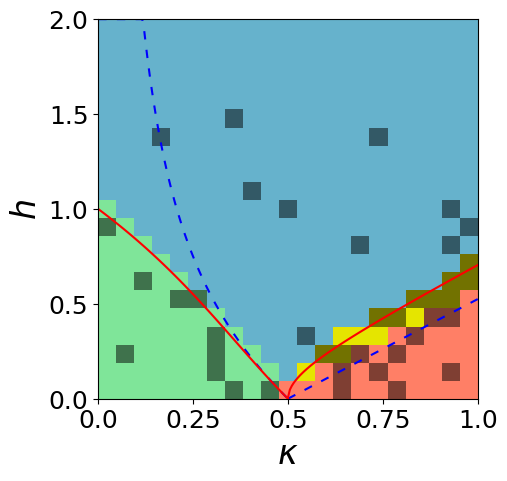

Generation: 0
Labels: [0 1 2 3]
Number of training points: 40


  0%|          | 0/1000 [00:00<?, ?it/s]/home/saverio/.local/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
Generation: 1/3:  67%|██████▋   | 2/3 [00:45<00:45, 45.82s/it]

[130 127  89   1  22  63 129 168  68  48 171 291 203 222 293 231 269 131
 303 383  34  11  60  18 103  62  35  56  40  41  32 145 167 146  78  99
  54  76 100 101]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


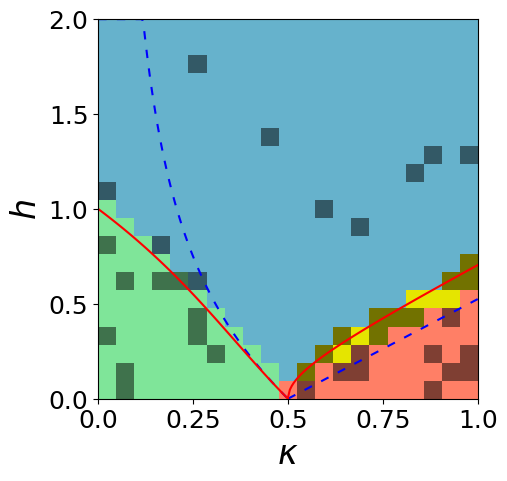

Generation: 1
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.13232: 100%|██████████| 1000/1000 [00:29<00:00, 34.27it/s]
Generation: 2/3: : 4it [01:17, 23.61s/it]                     

[ 42 105  87  25  21  46 169  64   6  24 247 200 244 391 215 337  71 330
 439 346 125 103  60  56  59  16  20  61  36  40 123  55  54 122 101  99
 146  78 124 167]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


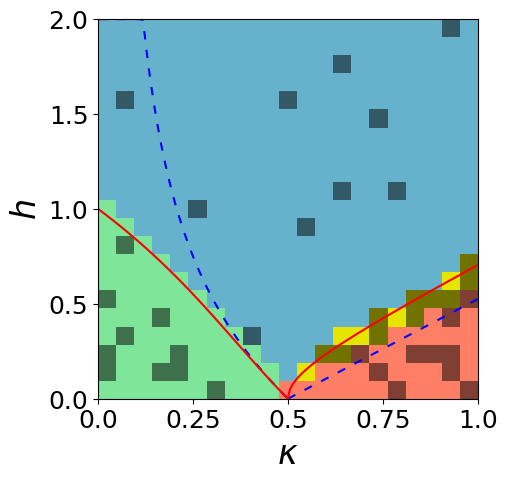

Generation: 2
Labels: [0 1 2 3]
Number of training points: 40


Generation: 2/3: 100%|██████████| 3/3 [01:49<00:00, 36.59s/it]


In [9]:
TT.train_rotate(True, False, 10, 1000, 3)

Array([[0.9231382 , 0.05979909, 0.01265872, 0.00369969],
       [0.9231382 , 0.05979909, 0.01265872, 0.00369969],
       [0.9324497 , 0.05498017, 0.00938312, 0.00303914],
       ...,
       [0.0658052 , 0.5686632 , 0.04699225, 0.3179119 ],
       [0.0667244 , 0.56450224, 0.04658257, 0.32137394],
       [0.06786925, 0.56019974, 0.04631456, 0.32502234]], dtype=float32)

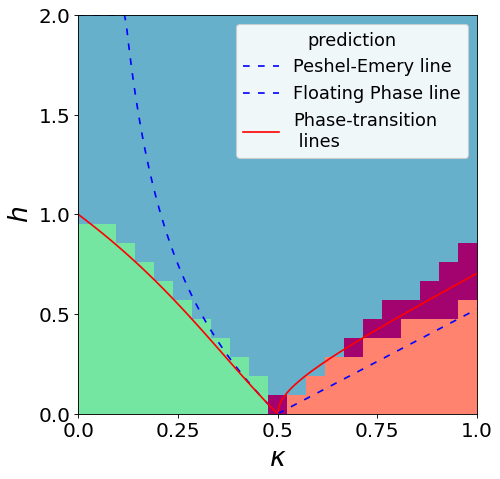

In [10]:
TT.predict(plot=True)

In [12]:
np.savetxt('./testparams', TT.qcnn.PARAMS)

Array([[0.27779064, 0.25750983, 0.27077985, 0.19288947],
       [0.27779064, 0.25750983, 0.27077985, 0.19288947],
       [0.22898242, 0.26162252, 0.24660175, 0.26182577],
       ...,
       [0.25512207, 0.23985527, 0.31373322, 0.18983638],
       [0.25498897, 0.23929814, 0.31322417, 0.19105709],
       [0.2548817 , 0.23878185, 0.31267375, 0.19230929]], dtype=float32)

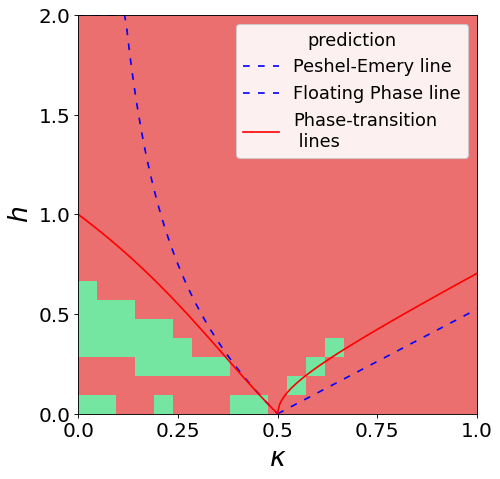

In [13]:
TT.qcnn.reset_params()
TT.predict(plot=True)

Array([[0.9231382 , 0.05979909, 0.01265872, 0.00369969],
       [0.9231382 , 0.05979909, 0.01265872, 0.00369969],
       [0.9324497 , 0.05498017, 0.00938312, 0.00303914],
       ...,
       [0.0658052 , 0.5686632 , 0.04699225, 0.3179119 ],
       [0.0667244 , 0.56450224, 0.04658257, 0.32137394],
       [0.06786925, 0.56019974, 0.04631456, 0.32502234]], dtype=float32)

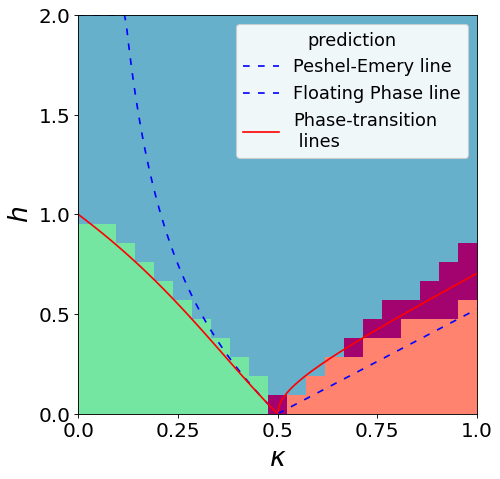

In [14]:
TT.qcnn.PARAMS = np.loadtxt('./testparams')
TT.predict(plot=True)

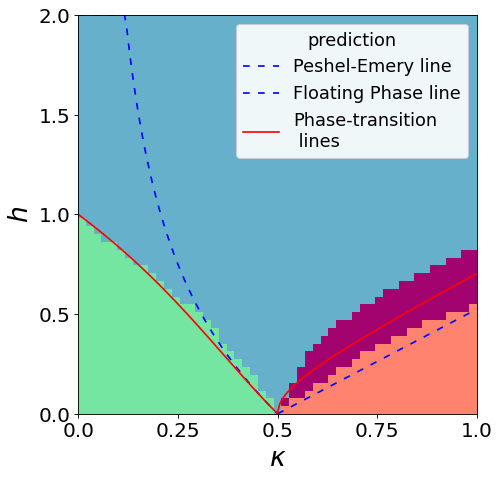

In [61]:
TT.predict(plot=True)

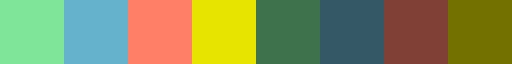

In [86]:
col8 = [[0.5, 0.9, 0.6, 1],
        [0.4, 0.7, 0.8, 1],
        [1.0, 0.5, 0.4, 1],
        [0.9, 0.9, 0.0, 1],
        [0.5/2, 0.9/2, 0.6/2, 1],
        [0.4/2, 0.7/2, 0.8/2, 1],
        [1.0/2, 0.5/2, 0.4/2, 1],
        [0.9/2, 0.9/2, 0.0/2, 1]]
# Relative colormaps
cm8 = ListedColormap(col8, name='color8')
cm8

In [4]:
TT.qcnn.reset_params()
TT.train(epochs=500, train_indices=X, labels4=True)

Labels: [0 1 2 3]
Number of training points: 40


  0%|          | 0/500 [00:00<?, ?it/s]/home/saverio/.local/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
Loss: 0.13454: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


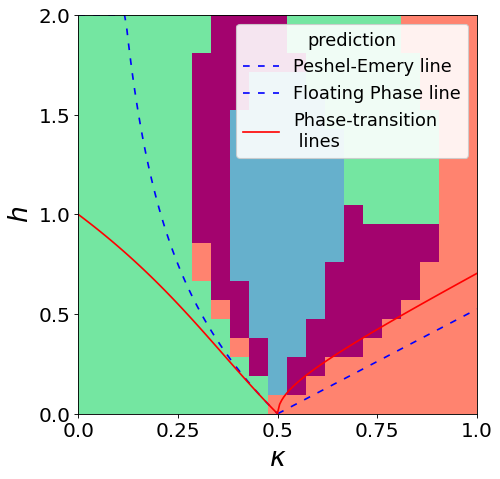

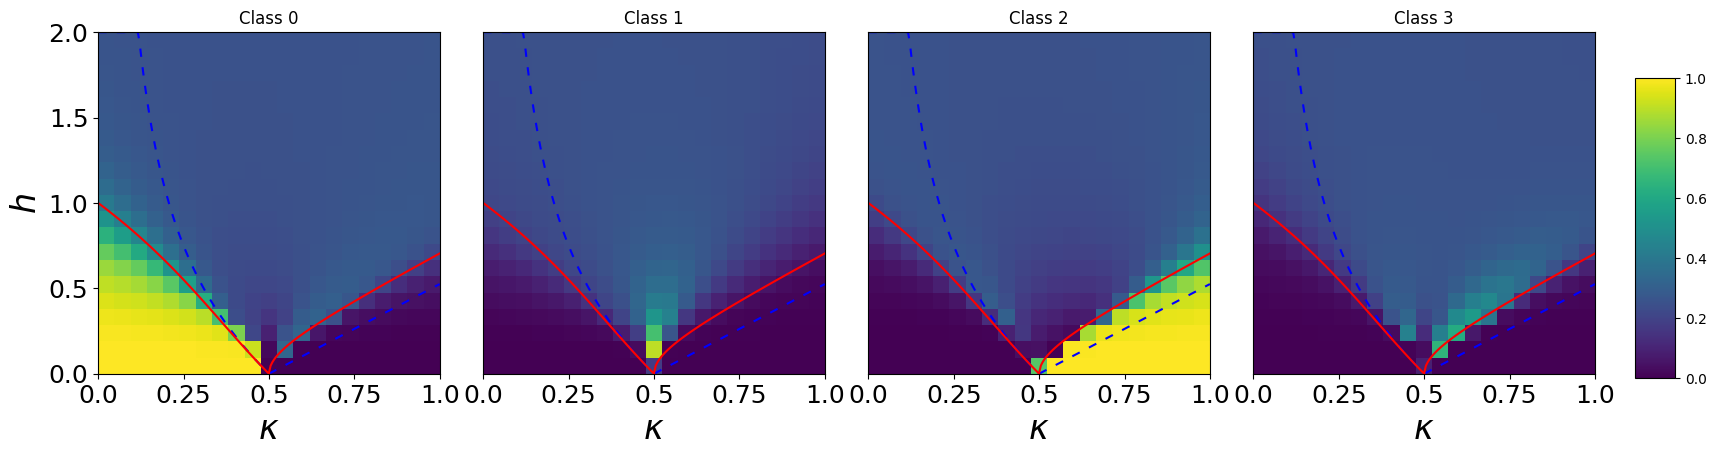

In [23]:
TT.predict(plot=True, eachclass = True)

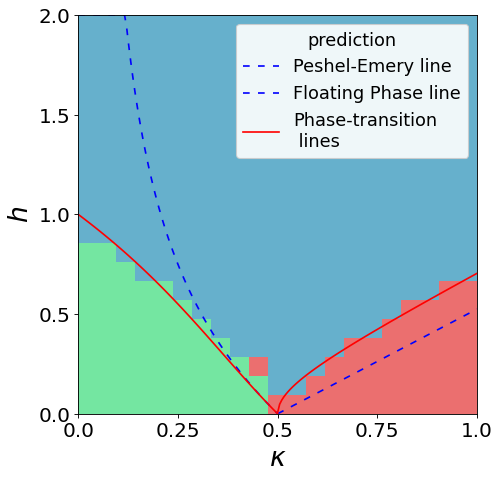

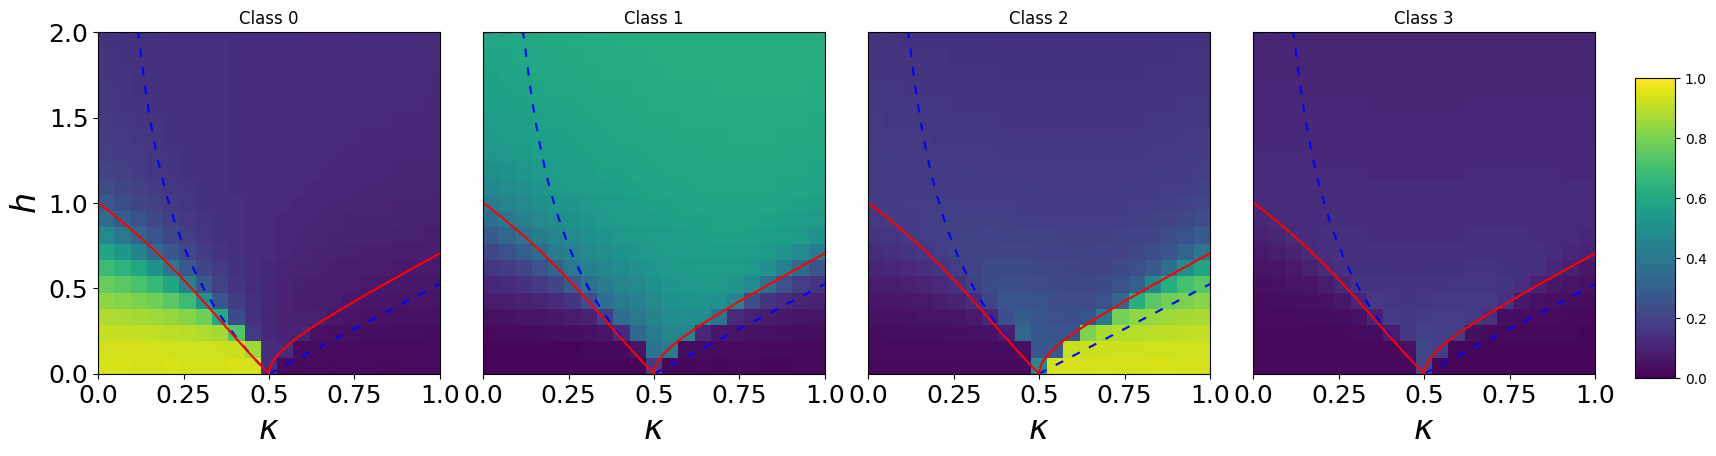

In [4]:
TT.predict(plot=True, eachclass=True)

## Training only using one of the three Phases:

In [5]:
import matplotlib.pyplot as plt
import numpy as np

20
Labels: [0]
Number of training points: 20


Loss: 0.02639: 100%|██████████| 250/250 [00:14<00:00, 17.18it/s]


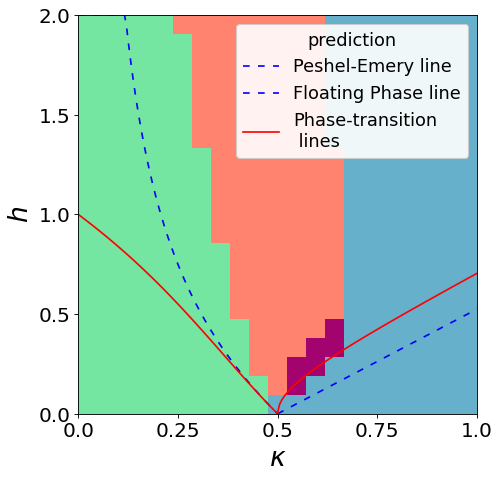

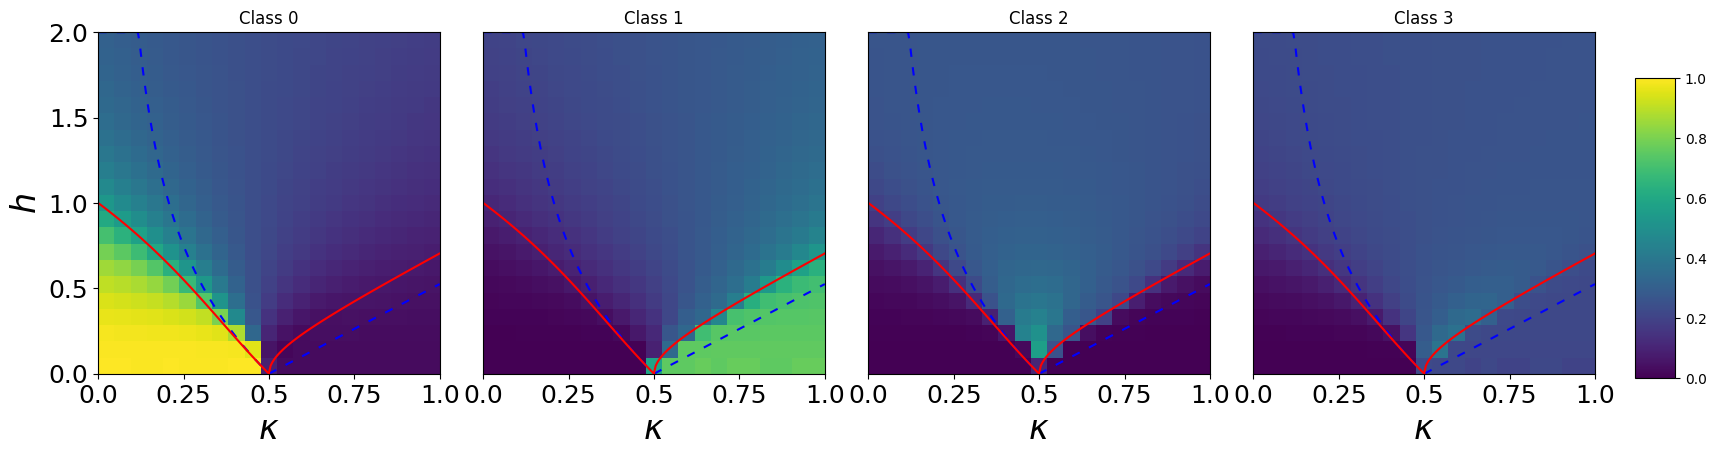

10
Labels: [1]
Number of training points: 10


Loss: 0.00988: 100%|██████████| 250/250 [00:11<00:00, 22.05it/s] 


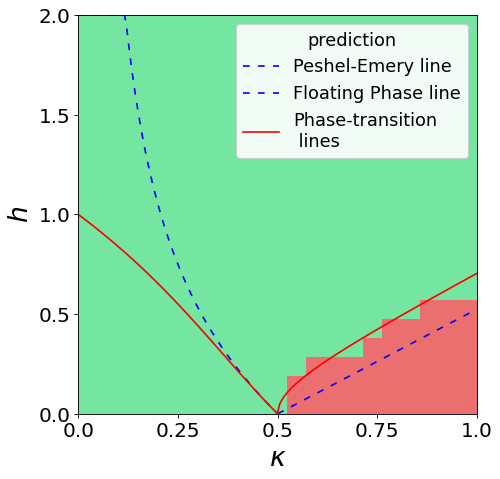

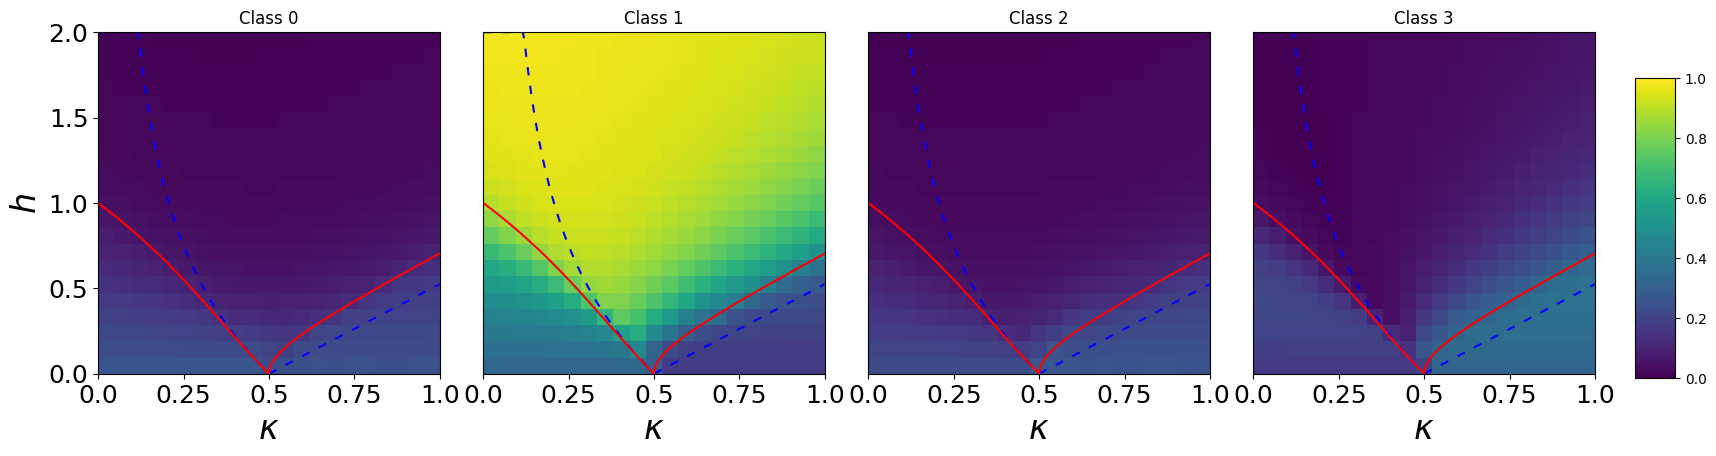

11
Labels: [2]
Number of training points: 11


Loss: 0.01251: 100%|██████████| 250/250 [00:11<00:00, 21.83it/s] 


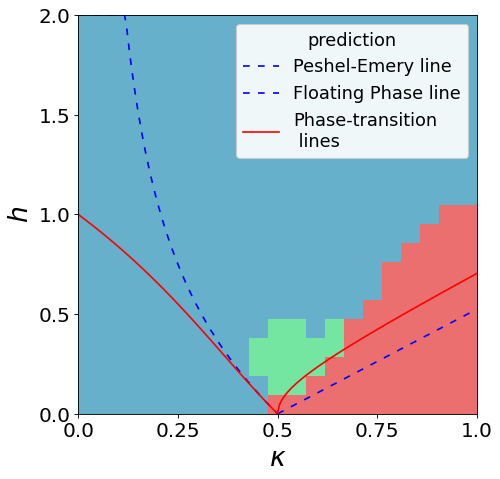

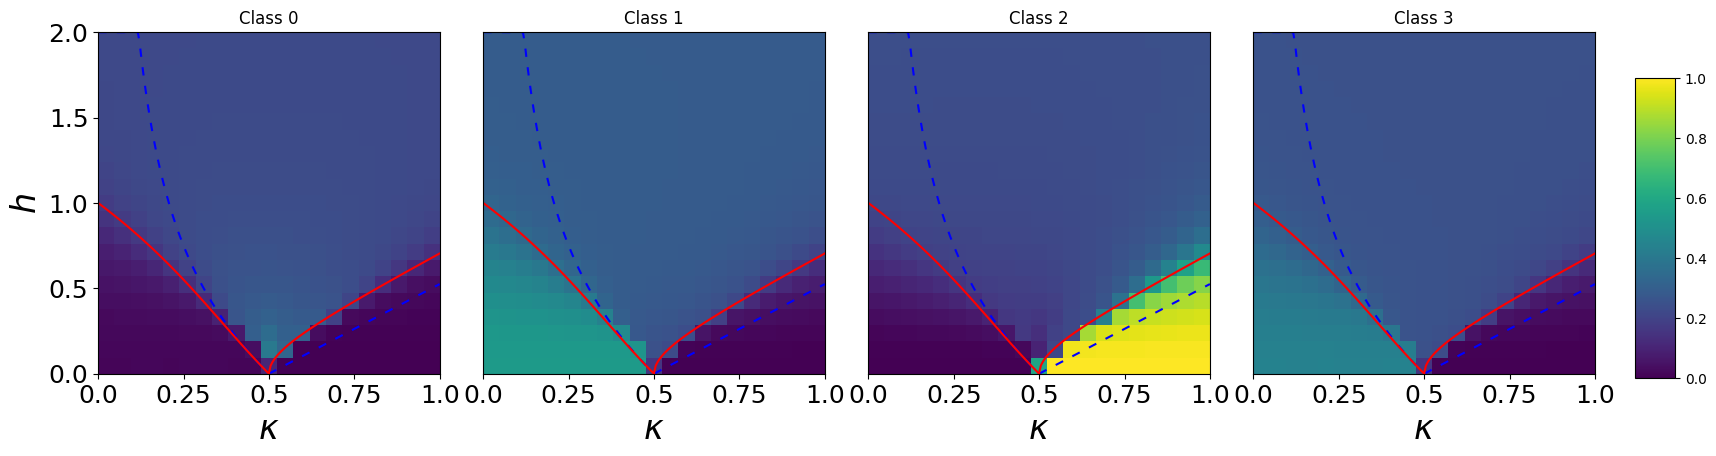

In [6]:
masks = [TT.mask_analitical_ferro, TT.mask_analitical_para, TT.mask_analitical_anti]

for mask in masks:
    print(sum(mask))
    TT.qcnn.reset_params()
    TT.train(epochs=250, train_indices=mask)
    TT.predict(plot=True, eachclass = True)
    plt.show()

## Training only using two of the three Phases:

Labels: [0 1]
Number of training points: 30


Loss: 0.05611: 100%|██████████| 250/250 [00:18<00:00, 13.34it/s]


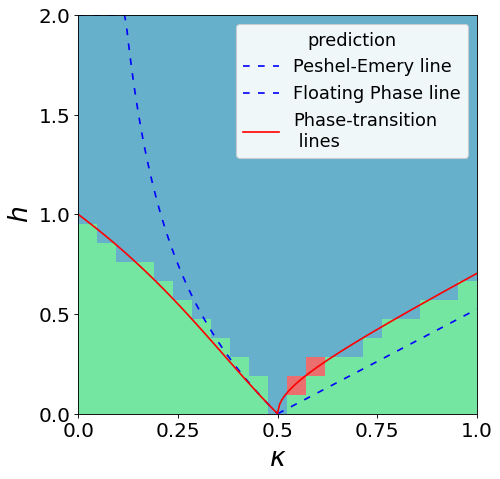

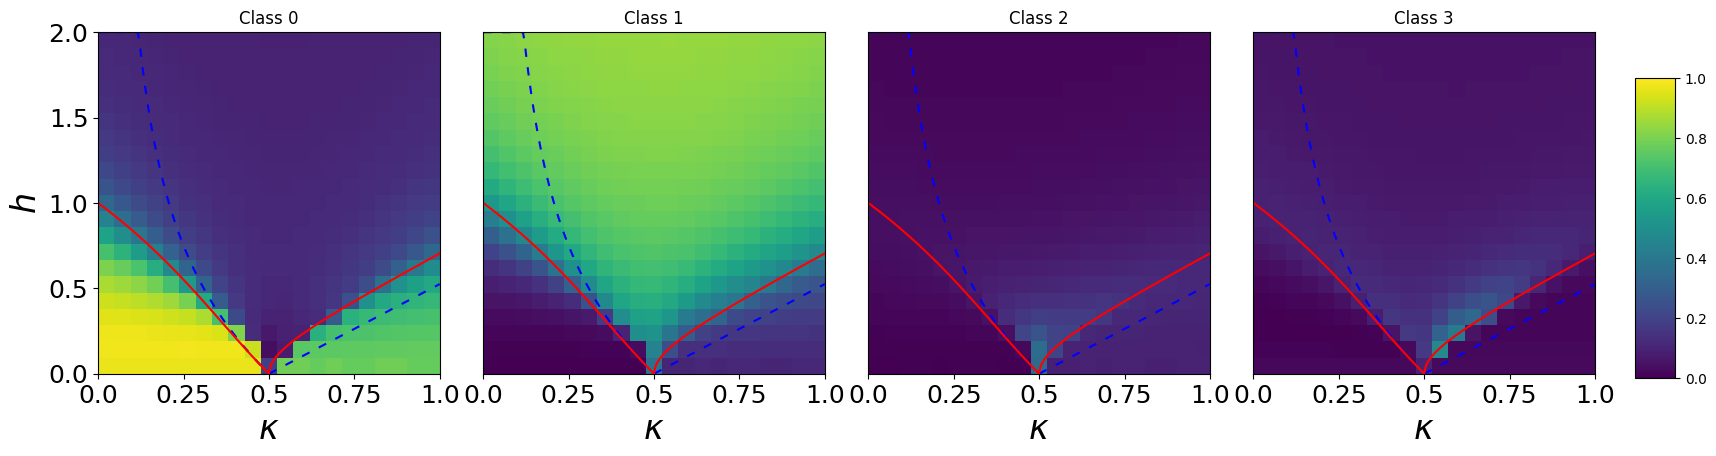

Labels: [0 2]
Number of training points: 31


Loss: 0.01869: 100%|██████████| 250/250 [00:19<00:00, 12.89it/s]


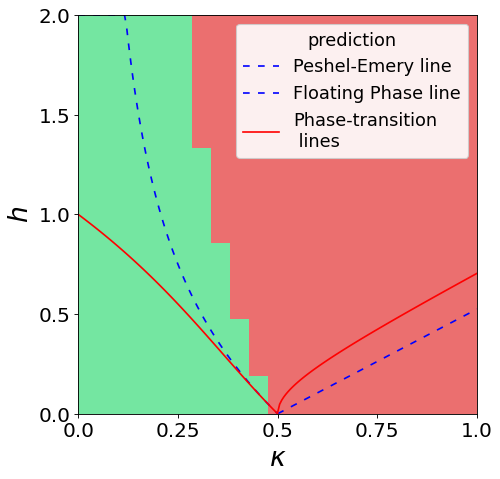

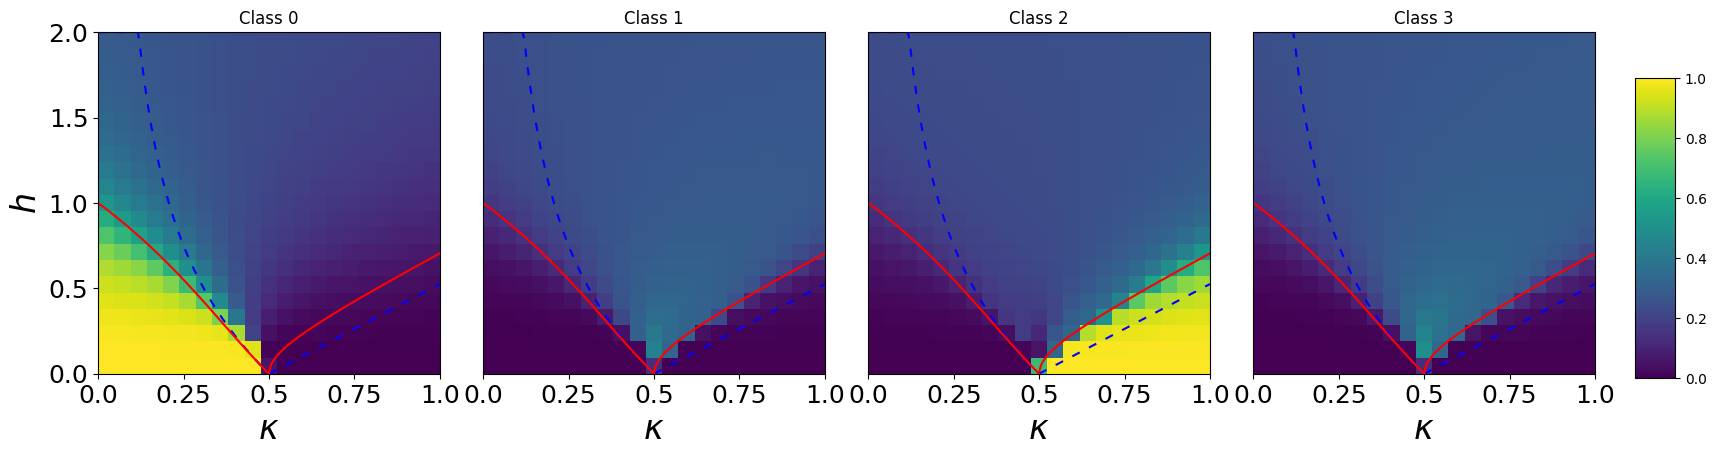

Labels: [1 2]
Number of training points: 21


Loss: 0.02760: 100%|██████████| 250/250 [00:15<00:00, 16.10it/s]


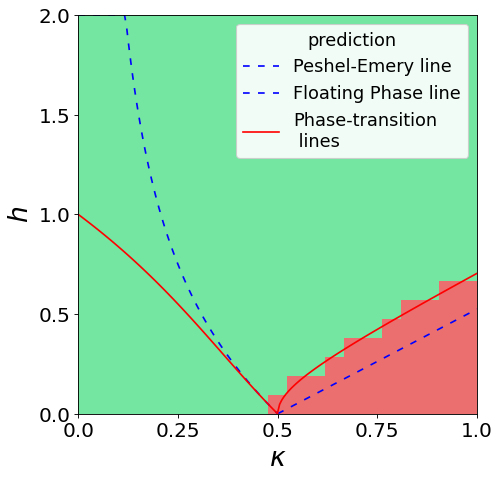

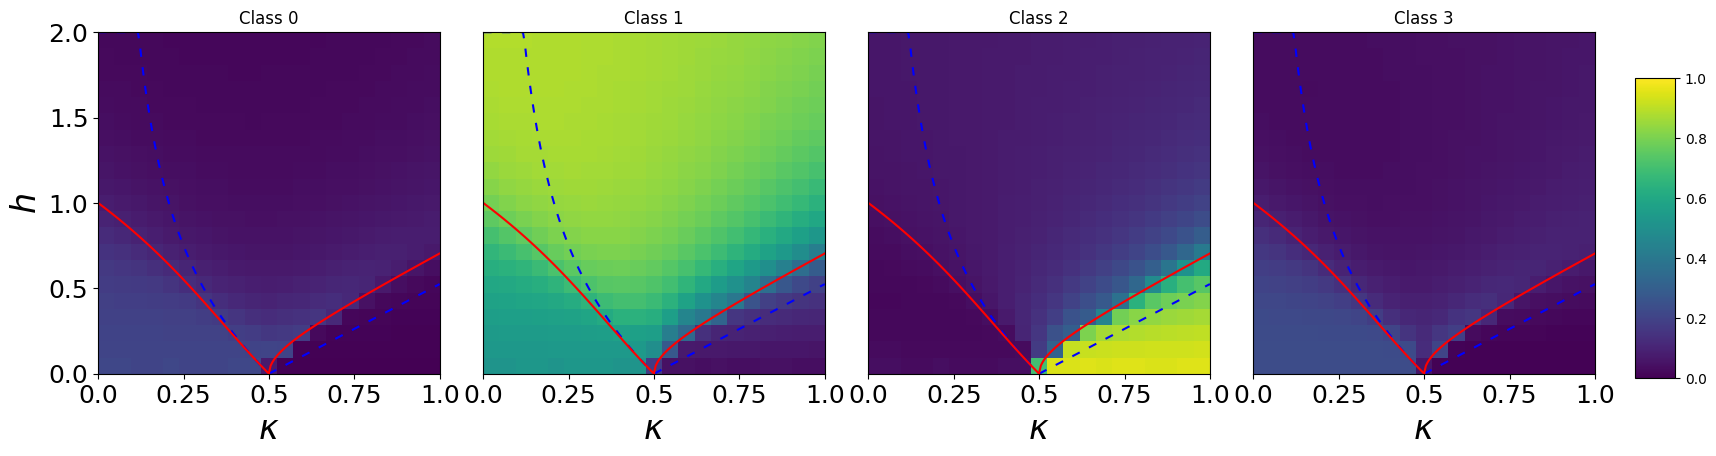

In [7]:
masks2 = [np.logical_or(masks[0], masks[1]), np.logical_or(masks[0], masks[2]), np.logical_or(masks[1], masks[2])]

for mask in masks2:
    TT.qcnn.reset_params()
    TT.train(epochs=250, train_indices=mask)
    TT.predict(plot=True, eachclass = True)
    plt.show()

In [6]:
import numpy as np

In [10]:
TT.labels4

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
TT.mask_analitical

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [14]:
np.array([True]*len(TT.labels4))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Labels: [0 1 2 3]
Number of training points: 441


  0%|          | 0/500 [00:00<?, ?it/s]/home/saverio/.local/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
Loss: 0.10376: 100%|██████████| 500/500 [02:43<00:00,  3.05it/s]


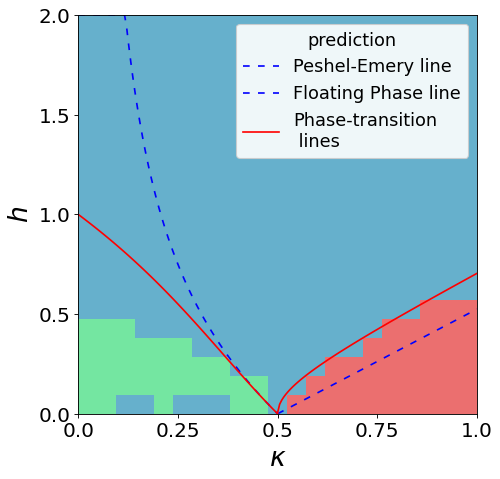

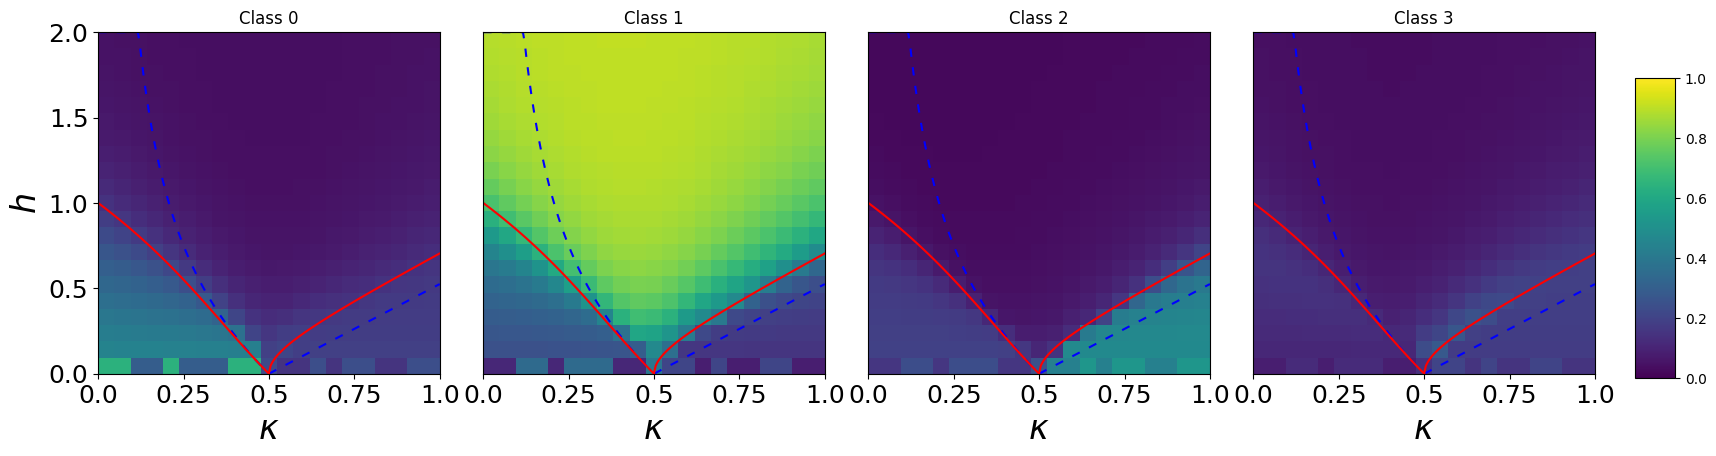

In [17]:
TT = ANNNI.mps(gpu=True)
TT.train(epochs=500, train_indices=np.array([True]*len(TT.labels4)), labels4=True)
TT.predict(plot=True, eachclass = True)

In [32]:
mask34 = np.logical_or(TT.labels4 == 3, TT.labels4 == 2)

Labels: [2 3]
Number of training points: 51


  0%|          | 0/500 [00:00<?, ?it/s]/home/saverio/.local/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
Loss: 0.09235: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]


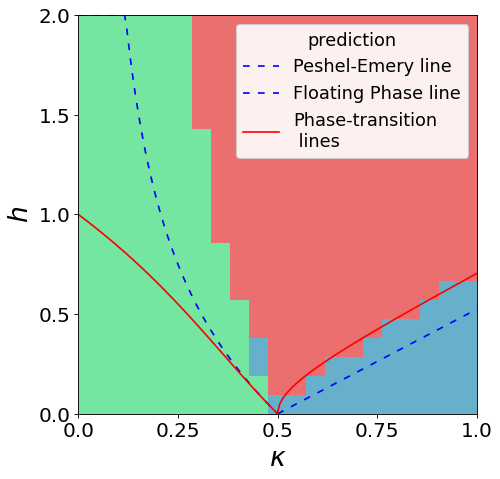

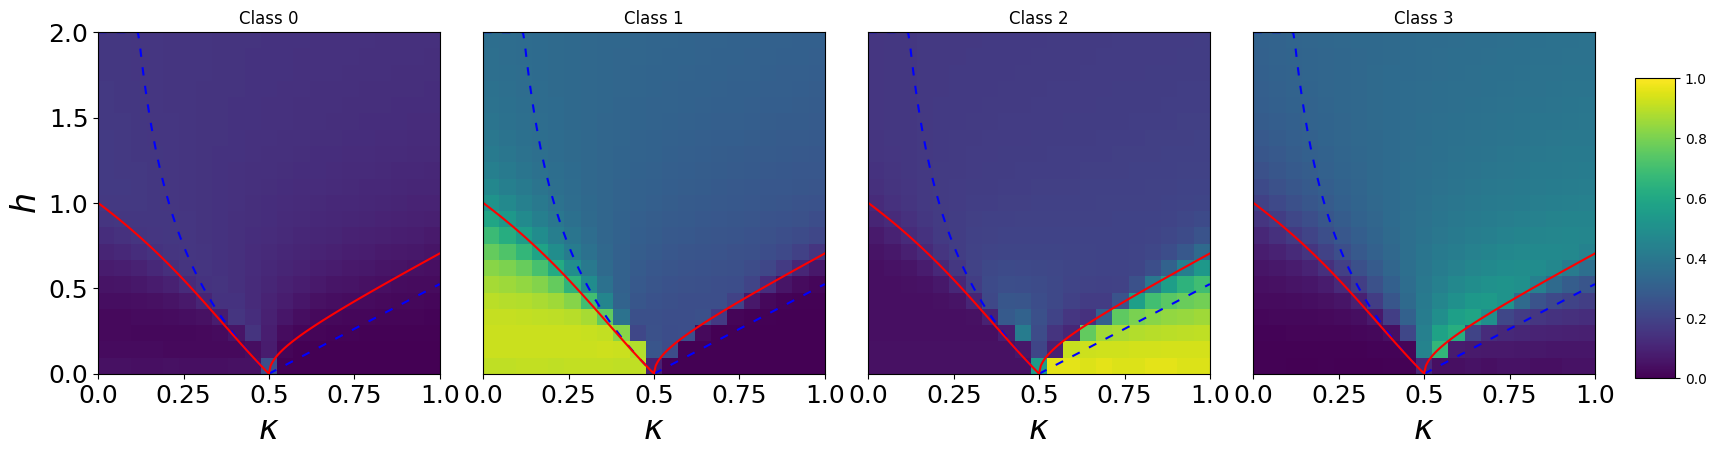

In [34]:
TT = ANNNI.mps(gpu=True)
TT.train(epochs=500, train_indices=mask34, labels4=True)
TT.predict(plot=True, eachclass = True)